In [1]:
import numpy as np
import os
import pandas as pd
import sys
import torch

import matplotlib.pyplot as plt

In [39]:
sys.path.append(os.path.join(sys.path[0], '../..'))

import endure.lsm.cost_model as Cost
from endure.lsm.solver import EndureLevelSolver
from endure.data.io import Reader
from endure.ltune.data.generator import LTuneGenerator
from endure.ltune.model.builder import LTuneModelBuilder
from endure.ltune.loss import LearnedCostModelLoss

In [40]:
config = Reader.read_config('../../endure.toml')
data_generator = LTuneGenerator(config)
cf = Cost.EndureLevelCost(config)
solver = EndureLevelSolver(config)

In [34]:
model_path = '/data/models/level-tuner-03-01'
model_config = Reader.read_config(os.path.join(model_path, 'endure.toml'))
model = LTuneModelBuilder(model_config).build_model()
model_data = torch.load(os.path.join(model_path, 'best.model'))
status = model.load_state_dict(model_data)
status

<All keys matched successfully>

In [35]:
def model_out_to_design(output):
    h = output[:, 0].item()
    size_ratio = torch.argmax(output[:, 1:]).item()
    return np.array([h, size_ratio + config['lsm']['size_ratio']['min']])

In [66]:
def eval_rand_workloads():
    WORKLOADS = 100
    df = []
    for _ in range(WORKLOADS):
        z0, z1, q, w = data_generator._sample_workload(4)
        # eval normal
        stune_h, stune_T = solver.find_nominal_design(z0, z1, q, w).x
        stune_T = np.ceil(stune_T)
        stune_h = np.around(stune_h, 3)
        stune_cost = cf(stune_h, stune_T, z0, z1, q, w)
        # eval learned
        x = torch.Tensor((z0, z1, q, w)).view(1, -1)
        ltune_h, ltune_T = model_out_to_design(model(x, hard=True))
        ltune_cost = cf(ltune_h, ltune_T, z0, z1, q, w)
        
        row = {
            'z0': z0,
            'z1': z1,
            'q': q,
            'w': w,
            'stune_h': stune_h,
            'stune_T': stune_T,
            'stune_cost': stune_cost,
            'ltune_h': ltune_h,
            'ltune_T': ltune_T,
            'ltune_cost': ltune_cost,
        }
        df.append(row)
    
    return pd.DataFrame(df)

In [67]:
df = eval_rand_workloads()
df['delta'] = (df['stune_cost'] - df['ltune_cost']) / df['stune_cost']

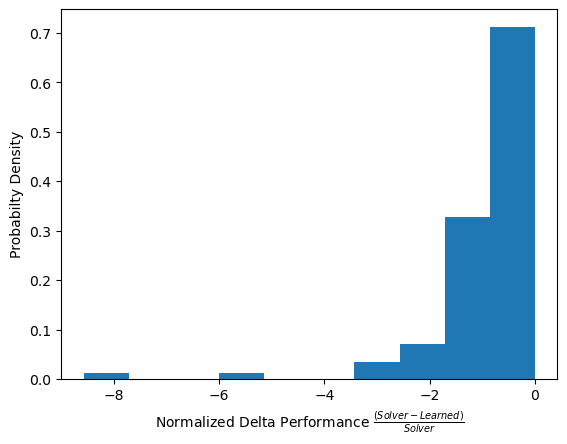

In [68]:
fig, ax = plt.subplots()
ax.hist(df['delta'], bins=10, density=True)
ax.set_ylabel('Probabilty Density')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
plt.show()

In [71]:
df.sort_values(by='stune_h', ascending=False).head(20)

,z0,z1,q,w,stune_h,stune_T,stune_cost,ltune_h,ltune_T,ltune_cost,delta
89,0.903,0.082,0.006,0.009,8.964,6.0,0.202351,0.0,33.0,1.277967,-5.315579
50,0.947,0.021,0.030,0.002,8.518,29.0,0.160869,0.0,9.0,1.538854,-8.565890
15,0.314,0.666,0.011,0.009,7.965,7.0,0.796816,0.0,35.0,1.217236,-0.527625
53,0.246,0.651,0.011,0.092,6.397,4.0,1.264865,0.0,50.0,2.930592,-1.316920
13,0.660,0.188,0.141,0.011,6.370,25.0,0.763688,0.0,36.0,1.429705,-0.872106
42,0.117,0.808,0.014,0.061,6.247,4.0,1.256770,0.0,44.0,2.176312,-0.731670
51,0.667,0.073,0.006,0.254,6.094,3.0,1.537814,0.0,47.0,6.028278,-2.920031
48,0.560,0.296,0.110,0.034,6.072,11.0,1.016354,0.0,47.0,1.839941,-0.810334
27,0.750,0.048,0.157,0.045,5.962,11.0,1.039002,0.0,14.0,1.880161,-0.809584
7,0.707,0.085,0.145,0.063,5.832,9.0,1.175282,0.0,40.0,2.329710,-0.982256


In [22]:
check = df[['z0', 'z1', 'q', 'w']].sum(axis=1)
check[check < 1]

Series([], dtype: float64)

In [57]:
loss_path = '/data/models/level-02-25/best.model'
loss_config = Reader.read_config('/data/models/level-02-25/endure.toml')
loss = LearnedCostModelLoss(loss_config, loss_path)

def eval_rand_workloads_lcm():
    WORKLOADS = 100
    df = []
    for _ in range(WORKLOADS):
        z0, z1, q, w = data_generator._sample_workload(4)
        x = torch.Tensor((z0, z1, q, w)).view(1, -1)
        # eval normal
        stune_h, stune_T = solver.find_nominal_design(z0, z1, q, w).x
        stune_T = np.ceil(stune_T)
        stune_h = np.around(stune_h, 3)
        stune_pred = torch.Tensor([stune_h, stune_T]).view(1, -1)
        stune_cost = loss(stune_pred, x).item()
        stune_cost = cf(stune_h, stune_T, z0, z1, q, w)
        # eval learned
        ltune_h, ltune_T = model_out_to_design(model(x, hard=True))
        ltune_pred = torch.Tensor([ltune_h, ltune_T]).view(1, -1)
        ltune_cost = loss(ltune_pred, x).item()
        
        row = {
            'z0': z0,
            'z1': z1,
            'q': q,
            'w': w,
            'stune_h': stune_h,
            'stune_T': stune_T,
            'stune_cost': stune_cost,
            'ltune_h': ltune_h,
            'ltune_T': ltune_T,
            'ltune_cost': ltune_cost,
        }
        df.append(row)
    
    return pd.DataFrame(df)

In [58]:
df = eval_rand_workloads_lcm()
df['delta'] = (df['stune_cost'] - df['ltune_cost']) / df['stune_cost']

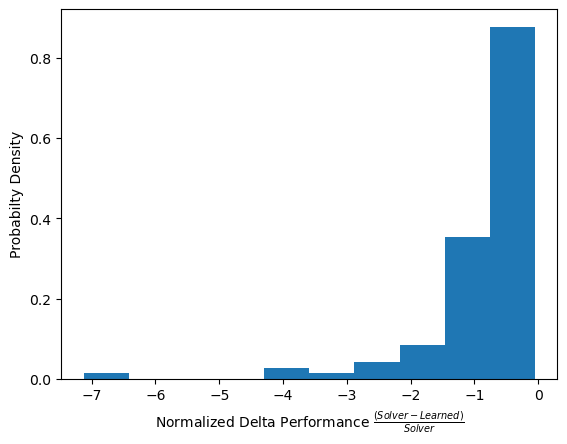

In [59]:
fig, ax = plt.subplots()
ax.hist(df['delta'], bins=10, density=True)
ax.set_ylabel('Probabilty Density')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
plt.show()

In [65]:
df.sort_values(by='delta', ascending=False).head(10)


,z0,z1,q,w,stune_h,stune_T,stune_cost,ltune_h,ltune_T,ltune_cost,delta
61,0.039,0.001,0.226,0.734,0.000,4.0,4.786705,0.0,30.0,5.041618,-0.053254
67,0.025,0.027,0.239,0.709,0.000,4.0,4.739237,0.0,27.0,5.053419,-0.066294
3,0.099,0.039,0.223,0.639,0.948,5.0,4.542461,0.0,40.0,5.006916,-0.102247
85,0.012,0.022,0.525,0.441,0.000,7.0,4.648257,0.0,47.0,5.221866,-0.123403
52,0.008,0.132,0.208,0.652,0.000,4.0,4.418902,0.0,44.0,4.987831,-0.128749
2,0.098,0.063,0.082,0.757,1.375,4.0,4.354366,0.0,17.0,4.928059,-0.131751
48,0.056,0.148,0.052,0.744,1.186,4.0,4.188252,0.0,12.0,4.789185,-0.143481
11,0.024,0.255,0.158,0.563,0.713,4.0,3.934868,0.0,12.0,4.520597,-0.148856
23,0.133,0.024,0.319,0.524,1.260,5.0,4.385382,0.0,13.0,5.042912,-0.149937
30,0.096,0.164,0.092,0.648,1.799,4.0,3.988949,0.0,15.0,4.744910,-0.189514
